### Data

In [14]:
import pandas as pd
import numpy as np

data = pd.read_csv("./bml-component-data.csv")

# Scale time column
data["timestamp"] /= 10000
data.head()

,ID,index,M1,M2,M3,M4,M5,timestamp,efficiency
0,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.00,97.644
1,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.01,90.796
2,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.03,80.454
3,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.04,83.102
4,CX-00,0,0.585,1.788,1.44,1.342,1.029,0.06,81.030


In [15]:
def pad(array, target_length):
    """
    Pads 1D array to target length using -1 constant as padding.
    e.g. pad([1,2,3], 5) -> [1,2,3,-1,-1]
    """

    n_pad = target_length - array.shape[0]
    return np.pad(array, (0, n_pad), mode="constant", constant_values=[-1])

In [16]:
# Collect all values from each CX into one row and put timestamps and efficiencies into np arrays
data_grouped = data.groupby(["ID"]).agg(list)
data_grouped = data_grouped.map(np.array)

# Each row i in x is all of the timestamps for CX-i
# Each row i in y is all of the corresponding efficiency values for CX-i
x = list(data_grouped["timestamp"])
y = list(data_grouped["efficiency"])

# Rows are ragged (rows aren't all the same length) so padding is required
# The rows are all padded to the length of the longest CX component.
max_obs = max([len(row) for row in y])

x_padded = np.array([pad(row, max_obs) for row in x])
y_padded = np.array([pad(row, max_obs) for row in y])

# Generate mask (True for actual values, False for padded values)
# e.g., the padded array [1,2,3,-1,-1] has a mask [True, True, True, False, False]
# which tells the model to only model the first three values in the array.
mask = x_padded != -1

### Baseline Model

Model the efficiency $y_i$ as a noisy exponential decay function $f_i$, with parameters $u_i$ and $v_i$:

$$y_i(t) = f_i(t) + \epsilon$$

$$f_i(t) = u_i \cdot \exp \left \{-v_i t \right \}$$

We omit the 10,000 divisor since we already divided the timestamp earlier.

In [17]:
import numpyro as npr
import numpyro.distributions as dist
import jax.numpy as jnp

def model(t, y, mask):
    # Define noise value to model epsilon
    sigma = npr.sample("sigma", dist.HalfNormal(1))

    # Generate u_i and v_i for all CX-i
    with npr.plate("cx-component", t.shape[0]):
        u = npr.sample("u", dist.Normal(90, 10))
        v = npr.sample("v", dist.Normal(5, 5))

    # Sample predictions in the feature dimension for each y value.
    with npr.plate("observations", t.shape[1]):
        # The mask handler ensures the model only learns from non-padded values
        with npr.handlers.mask(mask=mask):
            # Calcuate f_i(t)
            # jnp.newaxis ensures that multiplications are broadcasted correctly
            f = u[:, jnp.newaxis] * jnp.exp(-v[:, jnp.newaxis] * t)
            # Predict y_i(t) = f_i(t) + epsilon
            npr.sample("obs", dist.Normal(f, sigma), y)

In [18]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Usual mcmc setup
seed = 0
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(seed)
mcmc.run(rng_key, t=x_padded, y=y_padded, mask=mask)
mcmc.print_summary()

C:\Users\jayde\AppData\Local\Temp\ipykernel_3944\2908669415.py:9: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key, t=x_padded, y=y_padded, mask=mask)
sample: 100%|██████████| 1500/1500 [00:03<00:00, 416.00it/s, 31 steps of size 1.84e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      5.08      0.13      5.07      4.86      5.30   1967.06      1.00
      u[0]     91.95      2.53     91.83     87.70     95.89   2349.07      1.00
      u[1]     91.77      2.72     91.87     87.61     96.47   1709.10      1.00
      u[2]     92.65      2.79     92.73     88.19     97.43   2607.90      1.00
      u[3]     91.27      4.11     91.11     84.69     98.37   1820.16      1.00
      u[4]     88.60      4.49     88.42     81.05     95.59    924.80      1.00
      u[5]     97.59      6.84     97.83     86.19    108.05   1639.14      1.00
      u[6]     91.26      4.52     91.34     83.32     98.23   1511.57      1.00
      u[7]     90.80      4.52     90.76     83.61     97.93   2536.32      1.00
      u[8]    102.62      3.99    102.57     96.08    109.09   1408.78      1.00
      u[9]     89.08      4.37     89.03     82.33     95.95   2375.45      1.00
     u[10]    100.28      3

In [19]:
samples = mcmc.get_samples()

# Check the mean of v - it should be higher than the enhanced model 
jnp.abs(samples["v"]).mean()

Array(3.3227026, dtype=float32)

### Show some example plots to make sure its working

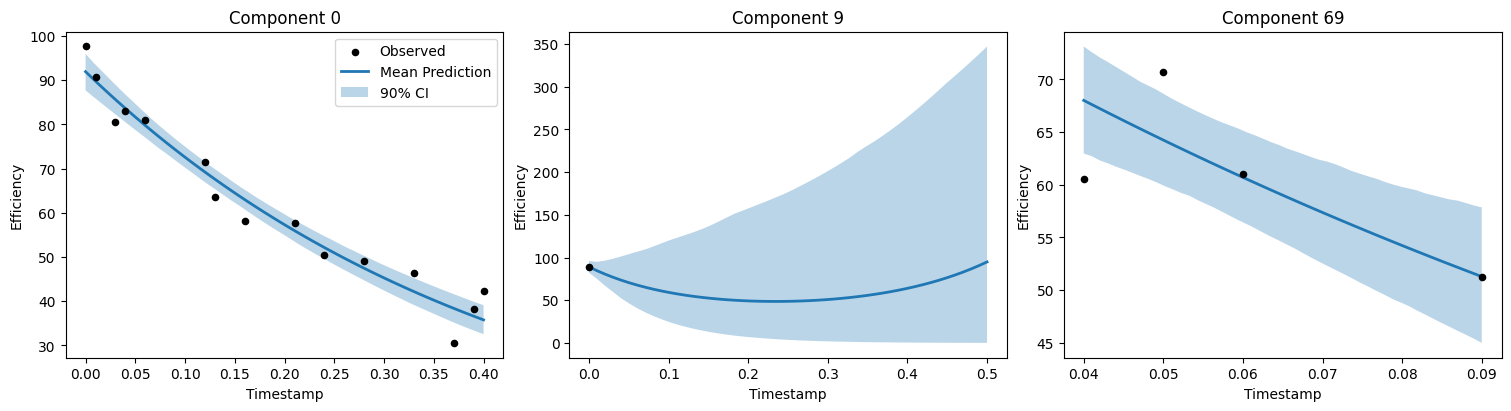

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

def plot_component_fits(samples, t, y, plot_indices):
    plot_indices = np.array(plot_indices)

    u = samples['u']
    v = samples['v']

    n = len(plot_indices)
    cols = 3
    rows = max(1, (n + cols - 1) // cols)

    _, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), constrained_layout=True)
    axes = np.atleast_1d(axes).flatten()

    for i, ax in zip(plot_indices, axes):
        t_i = t[i]
        y_i = y[i]
    
        t_linspace = jnp.linspace(t[i].min(), t[i].max()) if len(t[i]) > 1 else jnp.linspace(0, 0.5)

        u_i = u[:, i]
        v_i = v[:, i]
        preds = u_i[:, None] * jnp.exp(-v_i[:, None] * t_linspace)

        mean_pred = preds.mean(axis=0)
        low = jnp.percentile(preds, 5, axis=0)
        high = jnp.percentile(preds, 95, axis=0)

        ax.scatter(t_i, y_i, color="black", s=20, zorder=3, label="Observed")
        ax.plot(t_linspace, mean_pred, lw=2, label="Mean Prediction")
        ax.fill_between(t_linspace, low, high, alpha=0.3, label="90% CI")

        ax.set_title(f"Component {i}")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Efficiency")

    axes[0].legend()

    for ax in axes[n:]:
        ax.axis("off")

    plt.show()


plot_component_fits(samples, x, y, plot_indices=[0, 9, 69])